<a href="https://colab.research.google.com/github/youcef-benmohammed/blood.group.detection/blob/main/blood_group_detection_using_image_processing_and_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blood Group Detection Using Image Processing and Deep learning

## Introduction



Paper :
[A Novel Approach to Predict Blood Group using Fingerprint Map Reading](https://www.researchgate.net/publication/351487579_A_Novel_Approach_to_Predict_Blood_Group_using_Fingerprint_Map_Reading)

## 0. Load packages

In [1]:
# General libraries
import os
import glob
import shutil
import warnings
import time
import itertools
import pathlib

# Data handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Image handling and visualization
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress warnings
warnings.filterwarnings("ignore")

### Parmeters


In [2]:
# Define Constants
IMG_ROWS = 128
IMG_COLS = 128
BATCH_SIZE = 32

## 1. Dataset Preparation
* Import dataset and process file paths.

In [3]:
# Import the dataset from kaggle
# install Kaggle library
!pip install -q kaggle


In [4]:
# Upload Kaggle json file!
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset > /dev/null 2>&1
!unzip -q finger-print-based-blood-group-dataset.zip -d /content/dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
# Dataset directory path
file_path = '/content/dataset/dataset_blood_group/'

# List the labels and file paths
labels = os.listdir(file_path)
filepaths = list(glob.glob(file_path + '**/*.BMP', recursive=True))

# Map file paths to labels
labels_map = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Create a DataFrame with file paths and labels
df = pd.DataFrame({'filePath': filepaths, 'label': labels_map})

# Shuffle DataFrame
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,filePath,label
0,/content/dataset/dataset_blood_group/O+/cluste...,O+
1,/content/dataset/dataset_blood_group/B+/cluste...,B+
2,/content/dataset/dataset_blood_group/AB+/clust...,AB+
3,/content/dataset/dataset_blood_group/O+/cluste...,O+
4,/content/dataset/dataset_blood_group/B-/cluste...,B-


## 2. Class Distribution and Visualization
* Display and visualize class distribution.

A-                  :   1009 or 16.82%
O+                  :   852 or 14.2%
AB-                 :   761 or 12.68%
B-                  :   741 or 12.35%
O-                  :   712 or 11.87%
AB+                 :   708 or 11.8%
B+                  :   652 or 10.87%
A+                  :   565 or 9.42%


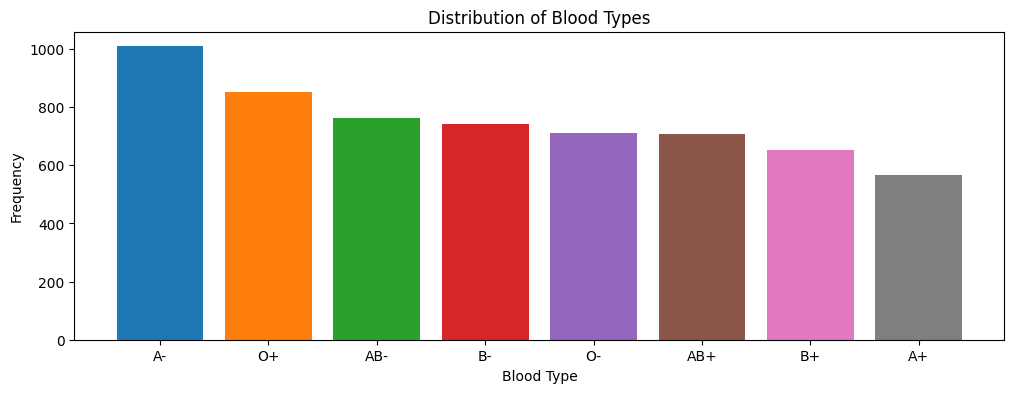

In [7]:

def get_class_distribution(df):
    labels_count = df['label'].value_counts()
    total_samples = len(df)
    for label, count in labels_count.items():
        percentage = round(count / total_samples * 100, 2)
        print(f"{label:<20s}:   {count} or {percentage}%")

# Display class distribution
get_class_distribution(df)

def plot_class_distribution(df, label="label"):
    plt.figure(figsize=(12, 4))
    blood_type_counts = df[label].value_counts()
    colors = plt.cm.tab10(range(len(blood_type_counts)))
    plt.bar(blood_type_counts.index, blood_type_counts.values, color=colors)
    plt.xlabel('Blood Type')
    plt.ylabel('Frequency')
    plt.title('Distribution of Blood Types')
    plt.show()

# Visualize distribution
plot_class_distribution(df)


## 3. Label Encoding

In [8]:
# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])

# Check encoded labels
df.head()

,filePath,label,category_encoded
0,/content/dataset/dataset_blood_group/O+/cluste...,O+,6
1,/content/dataset/dataset_blood_group/B+/cluste...,B+,4
2,/content/dataset/dataset_blood_group/AB+/clust...,AB+,2
3,/content/dataset/dataset_blood_group/O+/cluste...,O+,6
4,/content/dataset/dataset_blood_group/B-/cluste...,B-,5


## 4. Image Sampling and Visualization Functions
Sample Images: Visualize a subset of images to inspect the dataset.

Total number of sample images to plot: 32


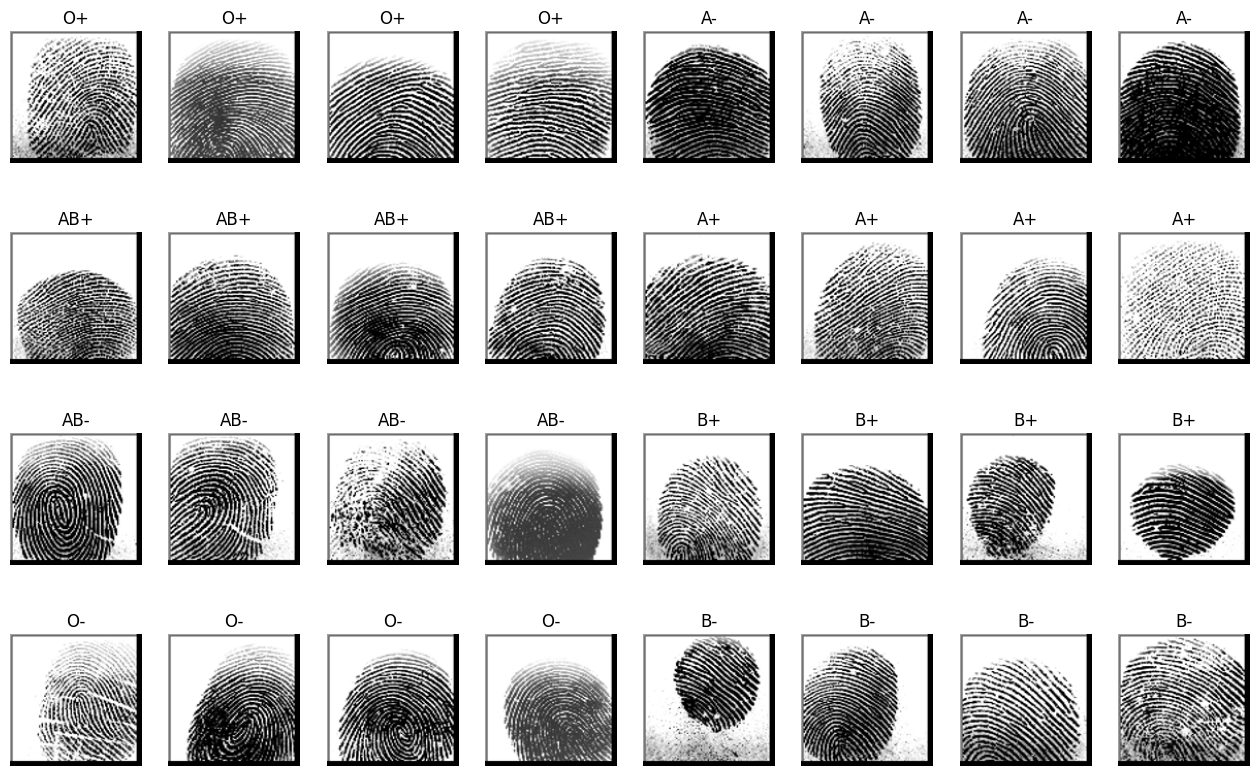

In [9]:
# Function to sample images and labels
# Function to sample images and labels
def sample_images_data(data, labels, num_samples=4):
    sample_images = []
    sample_labels = []

    # Iterate through each label and sample a few images
    # Changed: Iterate directly through the labels list
    for label in labels:
        samples = data[data['label'] == label].head(num_samples)
        for j in range(len(samples)):
            img_path = samples.iloc[j]['filePath']
            img = Image.open(img_path).convert("RGB")  # Open the image and convert to RGB
            img = img.resize((IMG_COLS, IMG_ROWS))  # Resize image to target size
            img_array = np.array(img)  # Convert image to numpy array
            sample_images.append(img_array)
            sample_labels.append(samples.iloc[j]['label'])

    print(f"Total number of sample images to plot: {len(sample_images)}")
    return sample_images, sample_labels

# Plot sample images
def plot_images(images, labels, cmap="Blues"):
    f, ax = plt.subplots(4, 8, figsize=(16, 10))
    for i, img in enumerate(images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[i])
    plt.show()

# Sample images from dataset and plot them
sample_images, sample_labels = sample_images_data(df, labels)
plot_images(sample_images, sample_labels)

## 5. Data Augmentation and Oversampling
Use RandomOverSampler to handle class imbalance


Class distribution after oversampling:
category_encoded
6    1009
4    1009
2    1009
5    1009
7    1009
1    1009
3    1009
0    1009
Name: count, dtype: int64


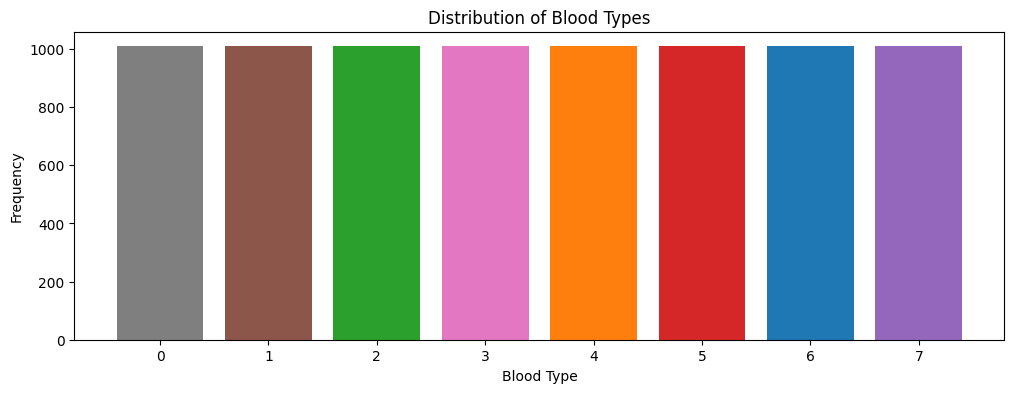

In [10]:
# Apply oversampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['filePath']], df['category_encoded'])

# Create a new DataFrame with oversampled data
df_resampled = pd.DataFrame(X_resampled, columns=['filePath'])
df_resampled['category_encoded'] = y_resampled

# Check new class distribution
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())

# Visualize new class distribution
plot_class_distribution(df_resampled, "category_encoded")

## 6. Data Splitting
Split the data into train, test and validation sets.


In [11]:
# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(
    df_resampled,
    train_size=0.8,
    stratify=df_resampled['category_encoded'],
    random_state=42
    )

valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['category_encoded'],
    random_state=42
    )

# Check the shape of the splits
train_df.shape, valid_df.shape, test_df.shape

((6457, 2), (807, 2), (808, 2))

## 7. Image Data Generators
* Prepare the data generators for training, validation, and testing.

In [12]:
# ImageDataGenerators for data preprocessing and augmentation
train_datagen = ImageDataGenerator(1./255)
valid_datagen = ImageDataGenerator(1./255)
test_datagen = ImageDataGenerator(1./255)

# Convert 'category_encoded' to string in all DataFrames
train_df['category_encoded'] = train_df['category_encoded'].astype(str)
valid_df['category_encoded'] = valid_df['category_encoded'].astype(str)
test_df['category_encoded'] = test_df['category_encoded'].astype(str)

# Create image generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filePath',
    y_col='category_encoded',
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode='rgb',)


valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filePath',
    y_col='category_encoded',
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode='sparse')

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filePath',
    y_col='category_encoded',
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

Found 6457 validated image filenames belonging to 8 classes.
Found 807 validated image filenames belonging to 8 classes.
Found 808 validated image filenames belonging to 8 classes.


## 8.  CNN Model Baseline
* This is a simple CNN model with 2 convolutional layers followed by fully connected layers.

In [13]:
def create_baseline_cnn(input_shape=(IMG_ROWS, IMG_COLS, 3), num_classes=8):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output of convolution layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

## 9. Pre-trained Models for Transfer Learning


### ResNet50

In [14]:
def create_resnet_model(input_shape=(IMG_ROWS, IMG_COLS, 3), num_classes=8):
    # Load the ResNet50 model without the top classification layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base_model.trainable = False  # Freeze the base model layers

    # Add custom layers on top
    model = models.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


### MobileNet

In [15]:
def create_mobilenet_model(input_shape=(IMG_ROWS, IMG_COLS, 3), num_classes=8):
    # Load MobileNetV1 pre-trained on ImageNet (exclude the top classification layers)
    base_model = MobileNet(
        include_top=False,             # Exclude the top layer
        weights='imagenet',            # Load pre-trained weights from ImageNet
        input_shape=input_shape,      # Define input shape
        pooling='avg'                  # Use average pooling to reduce dimensionality
    )

    # Freeze the base model layers (no training on them)
    base_model.trainable = False

    # Add custom layers for our task
    model = models.Sequential([
        base_model,                          # Add the MobileNetV1 base model
        layers.Dense(128, activation='relu'), # Add a fully connected layer
        layers.Dropout(0.5),                 # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy since labels are integer encoded
        metrics=['accuracy']
    )

    return model

## 10. Model Training
* Train the model with early stopping callback.

In [16]:
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Function to train and evaluate the model
def train_and_evaluate(model, train_gen, valid_gen, epochs=10):
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return history


## 11. Comparison: Baseline CNN vs. ResNet vs. MobileNet


In [17]:
# Create models
baseline_model = create_baseline_cnn(input_shape=(IMG_ROWS, IMG_COLS, 3), num_classes=8)
resnet_model = create_resnet_model(input_shape=(IMG_ROWS, IMG_COLS, 3), num_classes=8)
mobilenet_model = create_mobilenet_model(input_shape=(IMG_ROWS, IMG_COLS, 3), num_classes=8)

# Train and evaluate models
print("Training Baseline CNN Model:")
history_naive = train_and_evaluate(baseline_model, train_gen, valid_gen, epochs=50)

print("Training ResNet Model:")
history_resnet = train_and_evaluate(resnet_model, train_gen, valid_gen, epochs=50)

print("Training MobileNet Model:")
history_mobilenet = train_and_evaluate(mobilenet_model, train_gen, valid_gen, epochs=50)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training Baseline CNN Model:
Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 184s 890ms/step - accuracy: 0.1305 - loss: 135.3428 - val_accuracy: 0.1945 - val_loss: 2.0142
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 182s 903ms/step - accuracy: 0.2190 - loss: 1.9919 - val_accuracy: 0.1983 - val_loss: 1.9861
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 199s 887ms/step - accuracy: 0.2522 - loss: 1.9046 - val_accuracy: 0.2590 - val_loss: 1.9017
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 200s 877ms/step - accuracy: 0.2878 - loss: 1.8303 - val_accuracy: 0.2602 - val_loss: 1.9705
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 177s 874ms/step - accuracy: 0.3213 - loss: 1.7327 - val_accuracy: 0.2776 - val_loss: 2.0089
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 209s 912ms/step - accuracy: 0.3978 - loss: 1.5863 - val_accuracy: 0.2800 - val_loss: 1.9546
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 197s 886ms/step - accuracy: 0.4458 

In [18]:
# Plotting Training History for Comparison
def plot_history(history, model_name, plot_type):
    plt.plot(history.history[plot_type], label=f'{model_name} {plot_type}')
    plt.plot(history.history[f'val_{plot_type}'], label=f'{model_name} Val {plot_type}')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel(f'{plot_type}')
    plt.legend()
    plt.show()

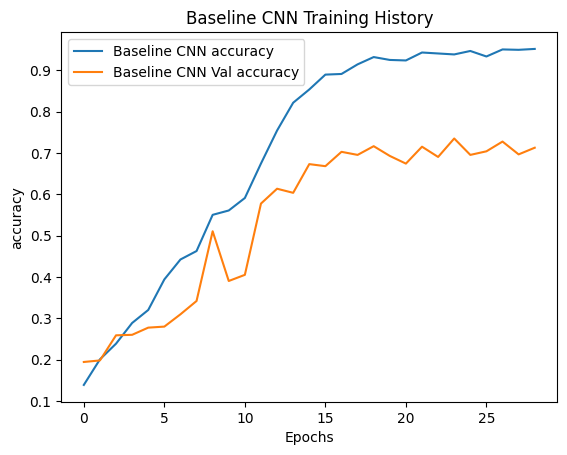

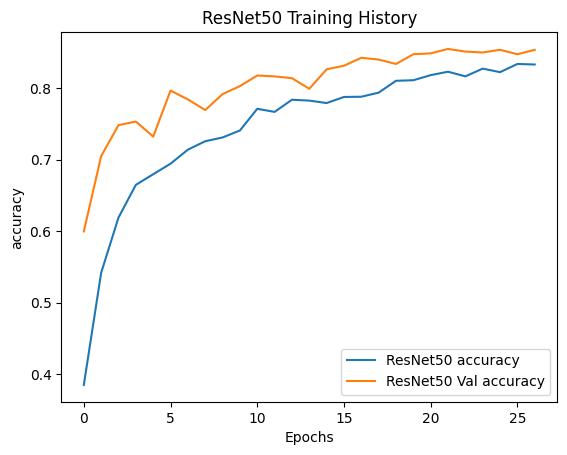

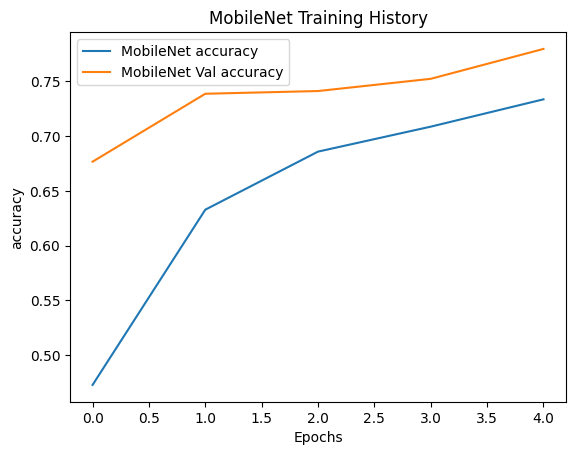

In [19]:
# Plot accuracy for each model
plot_history(history_naive, 'Baseline CNN', plot_type='accuracy')
plot_history(history_resnet, 'ResNet50', plot_type='accuracy')
plot_history(history_mobilenet, 'MobileNet', plot_type='accuracy')

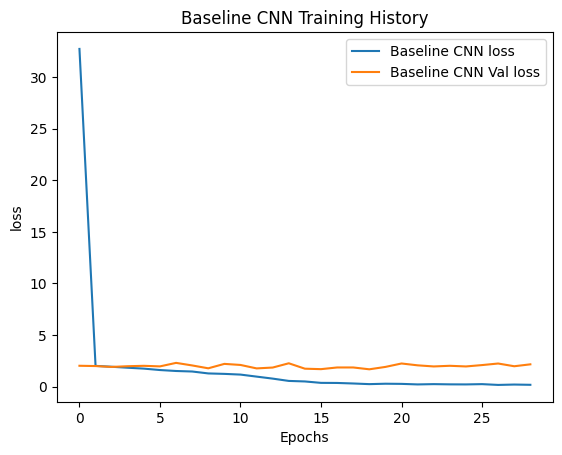

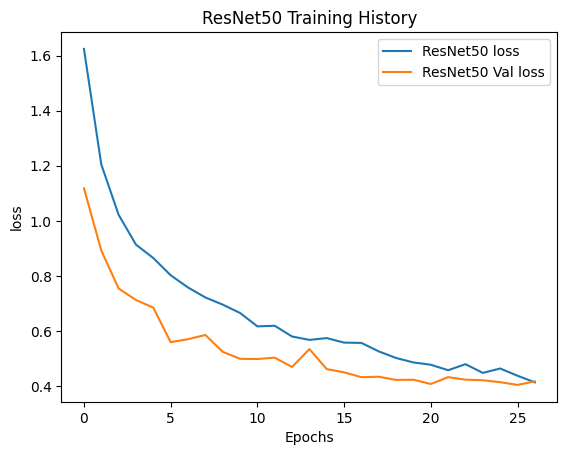

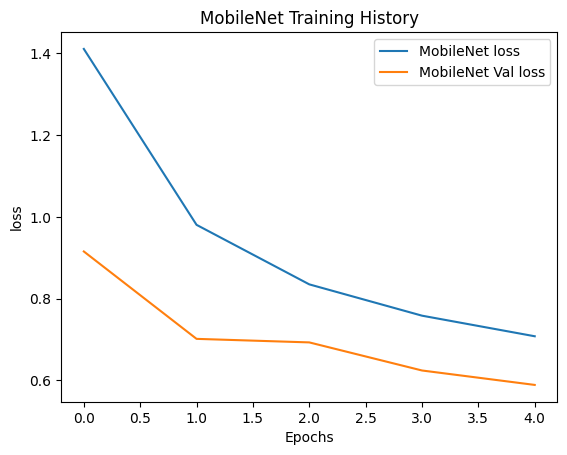

In [20]:
# Plot accuracy for each model
plot_history(history_naive, 'Baseline CNN', plot_type='loss')
plot_history(history_resnet, 'ResNet50', plot_type='loss')
plot_history(history_mobilenet, 'MobileNet', plot_type='loss')

In [23]:
test_labels = test_gen.classes
test_labels

[5,
 1,
 7,
 5,
 3,
 4,
 7,
 5,
 7,
 4,
 6,
 0,
 4,
 4,
 7,
 6,
 2,
 6,
 4,
 3,
 7,
 5,
 1,
 7,
 7,
 2,
 4,
 6,
 7,
 0,
 3,
 0,
 7,
 5,
 0,
 2,
 7,
 4,
 5,
 3,
 1,
 0,
 3,
 6,
 4,
 7,
 7,
 4,
 7,
 5,
 6,
 5,
 2,
 2,
 1,
 0,
 4,
 0,
 5,
 2,
 1,
 3,
 4,
 6,
 6,
 4,
 0,
 0,
 5,
 7,
 6,
 6,
 2,
 7,
 3,
 4,
 0,
 3,
 1,
 3,
 0,
 6,
 1,
 2,
 1,
 2,
 5,
 3,
 2,
 6,
 7,
 1,
 0,
 0,
 1,
 4,
 6,
 1,
 5,
 3,
 3,
 2,
 2,
 5,
 0,
 7,
 2,
 3,
 5,
 6,
 7,
 7,
 6,
 3,
 6,
 5,
 6,
 1,
 4,
 6,
 4,
 0,
 6,
 2,
 5,
 0,
 7,
 7,
 3,
 5,
 7,
 0,
 4,
 1,
 4,
 3,
 6,
 4,
 0,
 4,
 1,
 6,
 4,
 3,
 3,
 1,
 2,
 6,
 0,
 1,
 4,
 7,
 1,
 1,
 0,
 6,
 3,
 2,
 3,
 3,
 2,
 5,
 1,
 5,
 2,
 6,
 7,
 7,
 6,
 1,
 4,
 4,
 0,
 2,
 2,
 0,
 2,
 5,
 3,
 6,
 0,
 5,
 1,
 7,
 6,
 3,
 2,
 4,
 7,
 0,
 7,
 4,
 2,
 3,
 6,
 4,
 2,
 7,
 1,
 3,
 4,
 0,
 0,
 7,
 7,
 2,
 0,
 3,
 5,
 3,
 3,
 5,
 0,
 5,
 6,
 1,
 3,
 7,
 6,
 2,
 4,
 1,
 4,
 6,
 4,
 4,
 3,
 3,
 7,
 5,
 1,
 2,
 0,
 5,
 5,
 4,
 0,
 2,
 5,
 0,
 0,
 3,
 7,
 4,
 5,
 4,
 1,
 1,
 1,
 2,


In [24]:
results=resnet_model.evaluate(test_gen,verbose=0)
print("Test Loss:(:.5f)",format(results[0]))
print("Test Accuracy:(:.2f)%",format(results[1]*100))

Test Loss:(:.5f) 0.42640045285224915
Test Accuracy:(:.2f)% 85.27227640151978


In [26]:
results=baseline_model.evaluate(test_gen,verbose=0)
print("Test Loss:(:.5f)",format(results[0]))
print("Test Accuracy:(:.2f)%",format(results[1]*100))

Test Loss:(:.5f) 1.851452350616455
Test Accuracy:(:.2f)% 75.86633563041687


In [27]:
results=mobilenet_model.evaluate(test_gen,verbose=0)
print("Test Loss:(:.5f)",format(results[0]))
print("Test Accuracy:(:.2f)%",format(results[1]*100))

Test Loss:(:.5f) 0.9194447994232178
Test Accuracy:(:.2f)% 67.20296740531921


# TODO LISt

- **Ajustements de l’architecture :** Tester d’autres architectures de modèles CNN, ou à fine-tuner ResNet50 si les ressources le permettent.
    -  Augmenter le Drop-out pour éviter le sur-apprentissage 🔑

- **Evaulation des performances :** Ajout d'un métrique de la fonction loss, F1-score, matrice de confusion  


- **Interprétation des résultats :** Un aspect intéressant serait d'étudier les zones des empreintes digitales qui influencent le plus le modèle en utilisant des méthodes d'interprétabilité comme Grad-CAM.

- **Bilan des performances :** Documenter les performances de chaque groupe sanguin pour identifier les potentiels biais ou classes mal prédictibles. Matrice de confusion pour chaque classe par exemple.
